# Прогнозирование объема поставок

Компания «SFT» собрала исторические данные об объемах поставок сырья. Чтобы уменьшить время простоя грузчиков в период низкой нагрузки, необходимо спрогнозировать объем будущих поставок сырья.

Описание данных

* datetime - дата и время за каждый час
* target - вес нетто в тоннах

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
import keras.backend as K


In [2]:
df = pd.read_csv("G:\Downloads\мои доки\data science\solutions\datasets/df_sft_gr.csv", index_col = [0], parse_dates = [0])

## Исследовательский анализ данных

In [3]:
df

,target
datetime,
2023-01-02 10:00:00,21.78
2023-01-02 11:00:00,20.62
2023-01-02 12:00:00,0.00
2023-01-02 13:00:00,0.00
2023-01-02 14:00:00,0.00
...,...
2023-12-14 05:00:00,39.98
2023-12-14 06:00:00,0.00
2023-12-14 07:00:00,0.00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8304 entries, 2023-01-02 10:00:00 to 2023-12-14 09:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  8304 non-null   float64
dtypes: float64(1)
memory usage: 129.8 KB


In [5]:
df.describe()

,target
count,8304.000000
mean,20.931086
std,21.817824
min,0.000000
25%,0.000000
50%,19.820000
75%,39.175500
max,142.480000


>Доступны наблюдения за неполный год. В датасете большое количество нолевых значений.

In [6]:
def callPlot(dataset, title):
    sns.set(rc={'figure.figsize':(15,4)})
    dataset.plot(color=['darkorchid', 'mediumspringgreen'])
    plt.title(title)
    plt.xlabel('Период')
    plt.ylabel('Вес')
    plt.tight_layout()
    plt.show()

__По описанной ранее функции посмотрим на тренд, сезонность и шумы__

In [7]:
decomposed = seasonal_decompose(df.target)

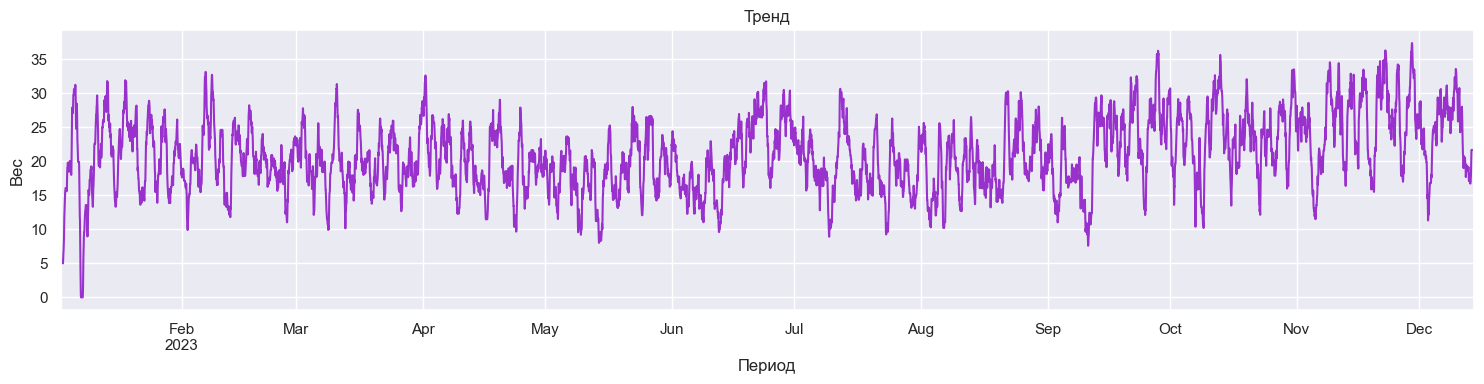

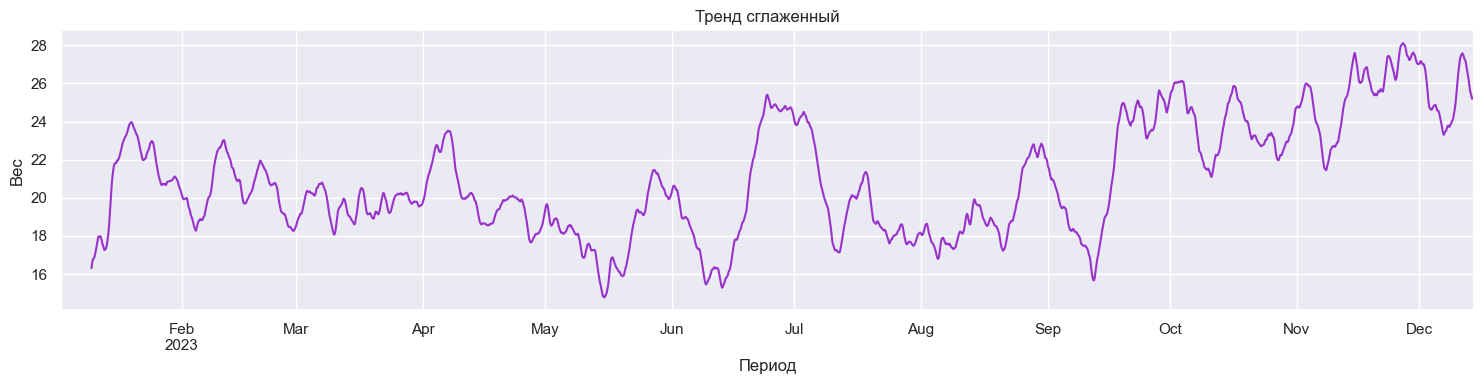

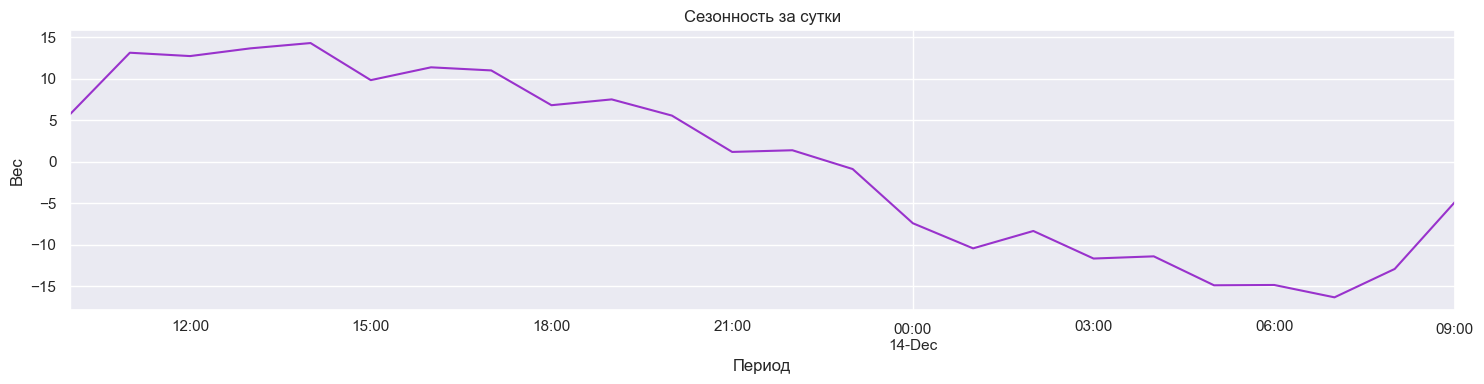

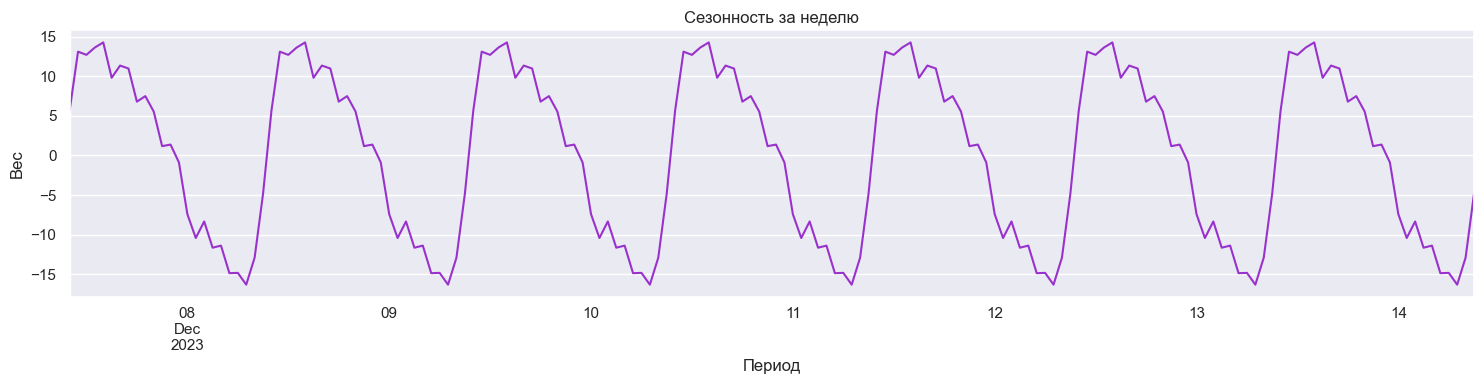

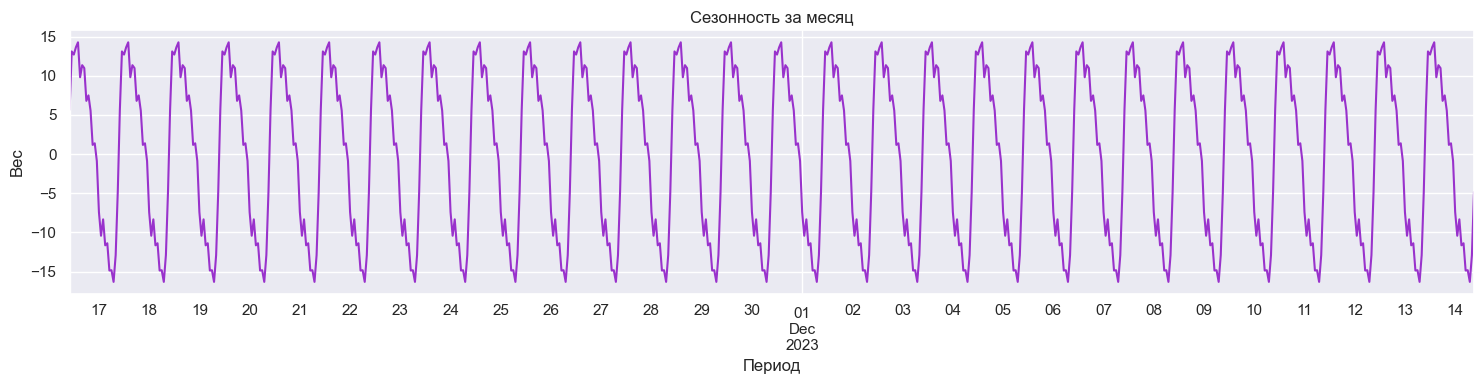

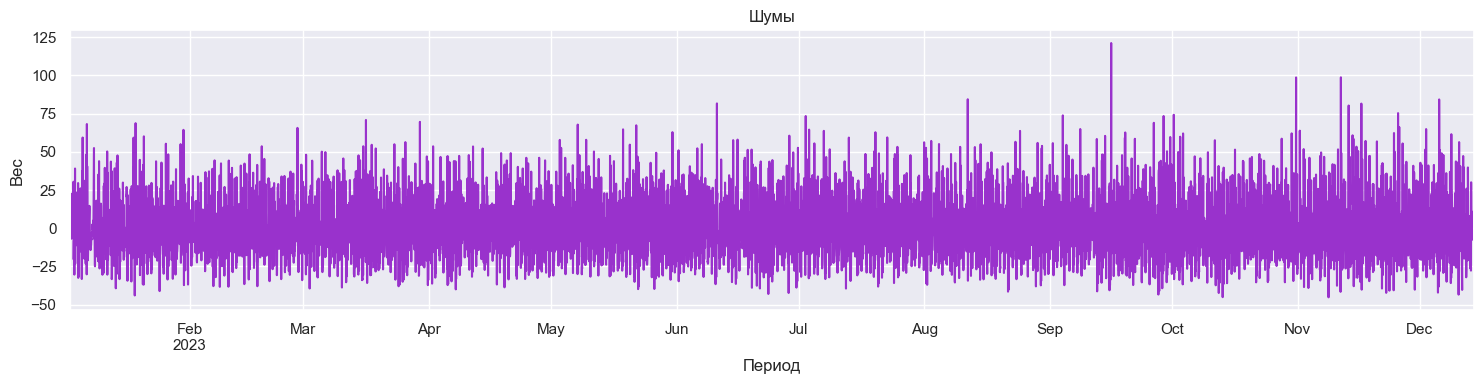

In [8]:
callPlot(decomposed.trend, 'Тренд')
callPlot(decomposed.trend.rolling(24*7, closed = 'left').mean(), 'Тренд сглаженный')
callPlot(decomposed.seasonal.tail(24), 'Сезонность за сутки')
callPlot(decomposed.seasonal.tail(24*7), 'Сезонность за неделю') 
callPlot(decomposed.seasonal.tail(24*7*4), 'Сезонность за месяц')
callPlot(decomposed.resid, 'Шумы')

>Пиковые объемы поставок пришлись на конец января, начало апреля, конец июня, с конца сентября начинается плавный рост с некоторыми спадами. Объем поставок сырья начинает расти с 6 утра, после 2 часов дня появляется спад. В датасете много 0 записей от того много шумов.

__Сформулируем гипотезы следующим образом, и проверим их__
       
  
  
  __Для теста Дики-Фуллера гипотезы такие:__

    
* H0: Временной ряд имеет единичный корень, то есть он нестационарен.
    
* H1: Временной ряд не имеет единичного корня, то есть он стационарен.
        
        
__Для теста Квятковского-Филлипса-Шмидта-Шина гипотезы такие:__
    
    
* H0: Временной ряд стационарен.
    
* H1: Временной ряд нестационарен.
    

In [9]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)



def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [10]:
display(adf_test(df.target))
kpss_test(df.target)

Results of Dickey-Fuller Test:
Test Statistic                -1.261813e+01
p-value                        1.600080e-23
Lags Used                      3.600000e+01
Number of Observations Used    8.267000e+03
Critical Value (1%)           -3.431141e+00
Critical Value (5%)           -2.861890e+00
Critical Value (10%)          -2.566956e+00
dtype: float64


None

Results of KPSS Test:
Test Statistic            2.787159
p-value                   0.010000
Lags Used                29.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\warri\AppData\Local\Temp\ipykernel_4484\628504314.py:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


>Результат теста Дики-Фуллера предполагает стационарность временного ряда, но наличие детерминистской тенденции в тесте KPSS указывает на нестационарность.

__Сгенерируем новые признаки со сдвигом до 7 часов и средним скользящим за сутки, также добавим день недели и номер часа__

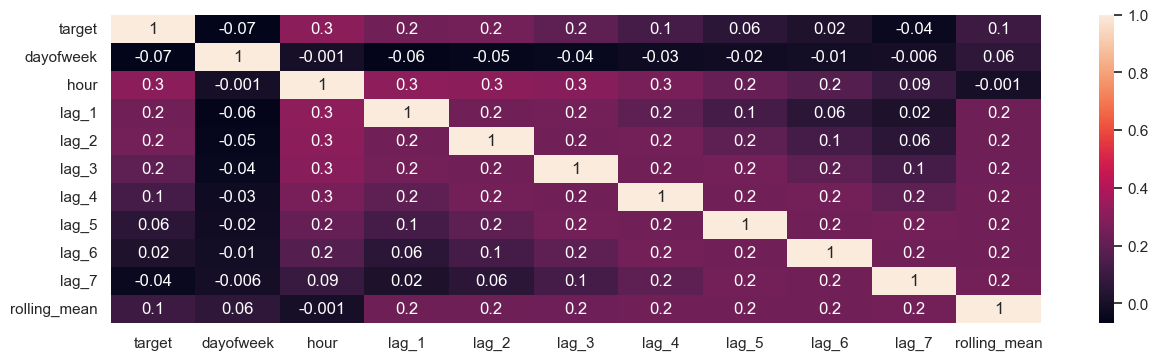

In [11]:
def make_features(dataset):
    dataset['dayofweek'] = dataset.index.dayofweek
    dataset['hour'] = dataset.index.hour

    for lag in range(1, 8):

        dataset['lag_{}'.format(lag)] = dataset.iloc[:,0].shift(lag)
    
    dataset['rolling_mean'] = dataset.iloc[:,0].shift().rolling(24).mean()

    return dataset

dataset = make_features(df)
dataset = dataset.dropna()
plt.figure(figsize=(15, 4))
sns.heatmap(dataset.corr(), annot=True, fmt ='.1g')
plt.show()

> Сгенерированные признаки слабо коррелируют между собой

## Построение моделей

__Разделим датасет на обучающую и тестовую выборки в соотношении 9/1, опишем функцию оптимизации для метода gridsearch, для кросс-валидации временного ряда используем метод timeseriessplit, для обучения рекурентной нейронной сети заранее стандартизируем фичи__

In [12]:
xTrain, xTest, yTrain, yTest = train_test_split(dataset.drop('target', axis=1),\
                                                dataset.target, test_size = 0.1, shuffle = False)
loss_fn = make_scorer(lambda y_true, y_pred: (mean_squared_error(y_true, y_pred)) ** 0.5,\
                      greater_is_better=False)
tscv = TimeSeriesSplit(n_splits=5)

scaler = StandardScaler()
xTrain_scaled = scaler.fit_transform(xTrain)
xTest_scaled = scaler.transform(xTest)

__Опишем функцию для обучения моделей и записи их результатов__

In [13]:
result=[]
def training(name_model, hyps):
    model1 = GridSearchCV(name_model(), hyps, n_jobs=-1, scoring=loss_fn, cv=tscv)
    model1.fit(xTrain, yTrain)
    result.append((name_model, model1.best_score_))

    return model1.best_estimator_

In [14]:
hyperparameters1 = {'verbose' : [0],
                   'iterations': [300, 400],
                   'grow_policy': ['Lossguide','Depthwise'],
                   'learning_rate': [0.01, 0.001],
                   'boosting_type': ['Plain'],
                   'depth': [4, 6]}
cbr = training(CatBoostRegressor, hyperparameters1)


hyperparameters2 = {'n_estimators' : [600, 800],
                    'max_depth': [6, 12],
                    'min_samples_leaf':[3, 6]}
rfc = training(RandomForestRegressor, hyperparameters2)


hyperparameters4 = {'fit_intercept': [True, False],
                   'gcv_mode': ['auto', 'svd', 'eigen']}
ridge = training(RidgeCV, hyperparameters4,)


__Построение 3-х слойной рекурентной нейросети, в качестве функции потерь использована - mse, в качестве метрики - rmse__

In [15]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

rnnmodel = Sequential()
rnnmodel.add(SimpleRNN(64, input_shape=(10, 1)))
rnnmodel.add(Dense(32, activation='relu'))
rnnmodel.add(Dense(1, activation='relu'))
rnnmodel.compile(optimizer='adam', loss='mse', metrics=root_mean_squared_error)

rnnmodel.fit(xTrain_scaled, yTrain, epochs=20, batch_size=3, verbose=2)



Epoch 1/20


2484/2484 - 7s - loss: 457.7645 - root_mean_squared_error: 19.4472 - 7s/epoch - 3ms/step
Epoch 2/20
2484/2484 - 6s - loss: 383.8149 - root_mean_squared_error: 17.6953 - 6s/epoch - 2ms/step
Epoch 3/20
2484/2484 - 6s - loss: 378.5480 - root_mean_squared_error: 17.5775 - 6s/epoch - 2ms/step
Epoch 4/20
2484/2484 - 6s - loss: 367.7978 - root_mean_squared_error: 17.3067 - 6s/epoch - 2ms/step
Epoch 5/20
2484/2484 - 6s - loss: 367.7124 - root_mean_squared_error: 17.3554 - 6s/epoch - 2ms/step
Epoch 6/20
2484/2484 - 6s - loss: 366.9532 - root_mean_squared_error: 17.3458 - 6s/epoch - 2ms/step
Epoch 7/20
2484/2484 - 6s - loss: 372.4168 - root_mean_squared_error: 17.4792 - 6s/epoch - 2ms/step
Epoch 8/20
2484/2484 - 6s - loss: 375.1270 - root_mean_squared_error: 17.5042 - 6s/epoch - 2ms/step
Epoch 9/20
2484/2484 - 6s - loss: 388.7967 - root_mean_squared_error: 17.7781 - 6s/epoch - 2ms/step
Epoch 10/20
2484/2484 - 6s - loss: 379.6582 - root_mean_squared_error: 17.6291 - 6s/epoch - 2ms/

In [16]:
preds_train = rnnmodel.predict(xTrain_scaled)
res = (mean_squared_error(yTrain, preds_train)) ** 0.5
result.append(('RNN', res))

result = pd.DataFrame(result, columns=['Модель', 'RMSE'])
result

233/233 [==============================] - 1s 1ms/step


,Модель,RMSE
0,<class 'catboost.core.CatBoostRegressor'>,-18.915800
1,<class 'sklearn.ensemble._forest.RandomForestR...,-19.019642
2,<class 'sklearn.linear_model._ridge.RidgeCV'>,-19.898138
3,RNN,18.879092


> Результаты на трейне не сильно отличаются, наименьшие ошибки у кэтбуст и нейросети

__Опишем функцию для сравнения фактических и спрогнозированных значений__

In [17]:
def callResult(pred, model_name):
    res = yTest.to_frame().reset_index()
    res['prediction'] = pred
    res.set_index('datetime', inplace=True)
    rmse = (mean_squared_error(yTest, pred)) ** 0.5
    rounded_rmse = round(rmse, 2)
    callPlot(res, 'Model: {0}, RMSE: {1}'.format(model_name,rounded_rmse))

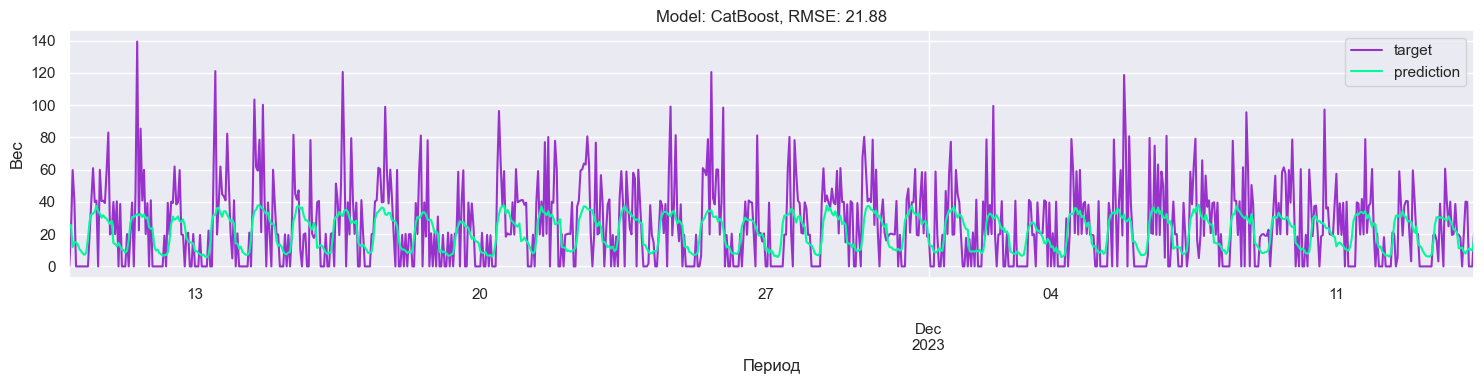

26/26 [==============================] - 0s 2ms/step


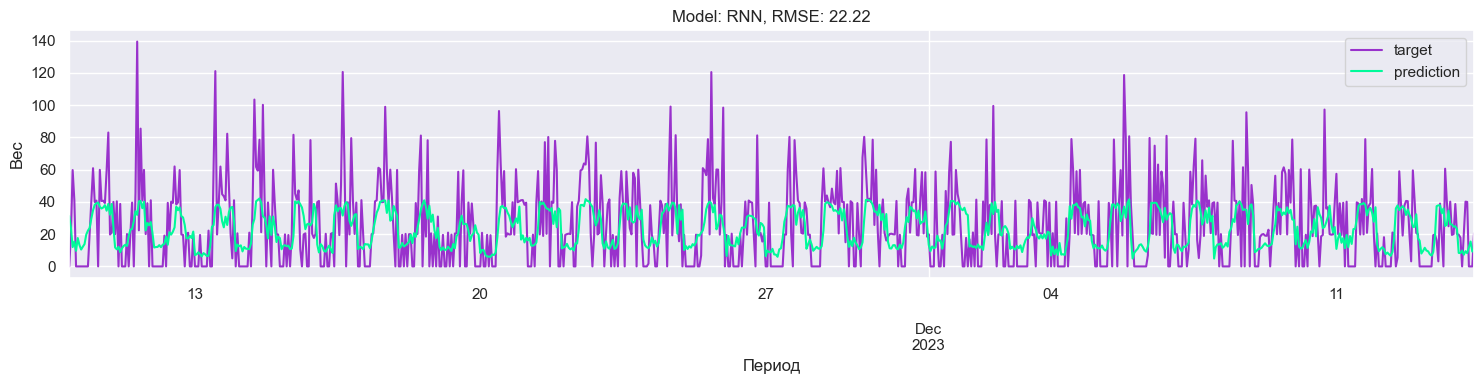

In [18]:
pred1= cbr.predict(xTest)
callResult(pred1, 'CatBoost')
pred2= rnnmodel.predict(xTest_scaled)
callResult(pred2, 'RNN')

> В целом модели посредственно справляются с прогнозом

__Посмотрим на важность признаков для кэтбуста и нейросети__

In [19]:
xTrain_scaled = tf.convert_to_tensor(xTrain_scaled, dtype=tf.float32)
with tf.GradientTape() as tape:
    tape.watch(xTrain_scaled)
    y_pred = rnnmodel(xTrain_scaled)
gradients = tape.gradient(y_pred, xTrain_scaled)
feature_importance1 = np.mean(np.abs(gradients), axis=0)

In [20]:
feature_importances = cbr.feature_importances_
feature_names = xTrain.columns

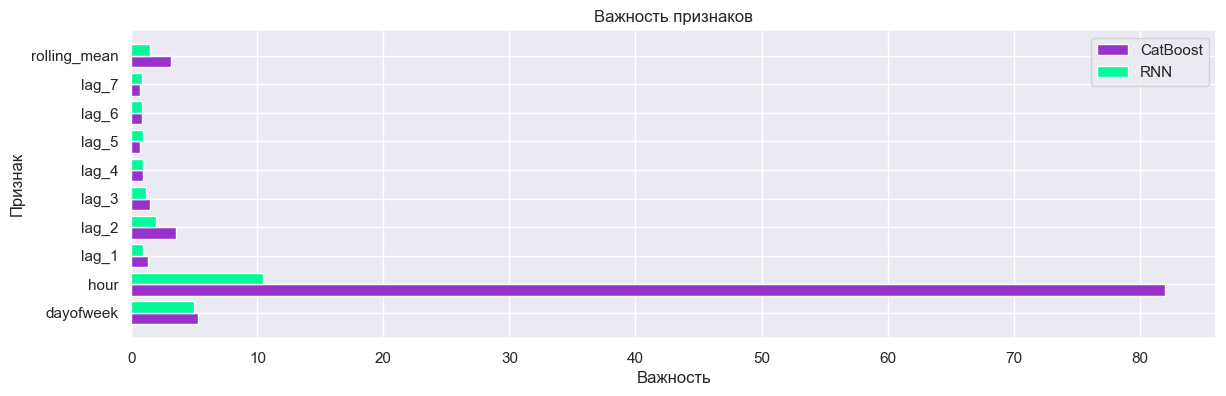

In [21]:

fig, ax = plt.subplots(figsize=(14, 4))
ax.barh([i - 0.4/2 for i in range(len(feature_importances))], feature_importances, height=0.4, color='darkorchid', label='CatBoost')
ax.barh([i + 0.4/2 for i in range(len(feature_importance1))], feature_importance1, height=0.4, color='mediumspringgreen', label='RNN')

ax.set_xlabel('Важность')
ax.set_ylabel('Признак')
ax.set_title('Важность признаков')
ax.set_yticks(range(len(feature_names)))
ax.set_yticklabels(feature_names)
ax.legend()

plt.show()

> Обе модели считают, что признак часа достаточно сильно влияет на целевую, однако у модели кэтбуста достаточно высокое значение в сравнении с нейросетью

## Заключение

В ходе работы было выявлено:
* Прослеживается рост объема поставок после июньского и сентябрьского спада
* Большое количество записей с объемом поставок равным 0

Результат построения моделей прогонозирования можно считать неудачным, даже если ошибка в 21 тонну неслишком велика для использования модели на предприятии. Возможно стоило переформулировать задачу таким образом, чтобы прогнозировать факт поставки к определенному времени, так как в данных много нолевых значений.

В целях улучшения результатов прогнозирования моделей можно изменить параметры алгоритма генерации признаков или подобрать более подходящие гиперпараметры для моделей.